# 모듈

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from clf_evaluation import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from visualization import *

%matplotlib inline

rc('font', family='Malgun Gothic')
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('../data/train.csv/train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
df_ohe = pd.get_dummies(df[['Geography', 'Gender']])
pre_ohe = df.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, df_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False,False,True,0
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False,False,True,0
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False,False,True,0
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False,False,True,0
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True,False,True,0


In [4]:
X = data.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=13)
X_ovr, y_ovr = smote.fit_resample(X_train, y_train)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_ovr.shape, y_ovr.shape)

(132027, 13) (33007, 13) (132027,) (33007,)
(208122, 13) (208122,)


## 로지스틱 회귀

1. Exited - 불균형 상태

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_eval(y_test, lr_pred, lr_proba[:, 1])

Confusion Matrix
[[25139   913]
 [ 6085   870]]
Accuracy: 0.788 Precision: 0.4879 Recall: 0.1251
F1: 0.1991 ROC AUC: 0.7152


2. Exited - "class_weight = 'balanced'"

In [7]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_eval(y_test, lr_pred, lr_proba[:, 1])

Confusion Matrix
[[17728  8324]
 [ 2209  4746]]
Accuracy: 0.6809 Precision: 0.3631 Recall: 0.6824
F1: 0.474 ROC AUC: 0.7367


- accuracy, precision이 하락하는 대신 recall이 크게 개선되어 auc_score가 소폭 상승
- 타겟 데이터 불균형의 해소로 모델의 성능이 개선

> Recall, Precision의 의미
- recall : 실제 이탈 고객 중 모델이 얼마나 많은 이탈 고객을 올바르게 예측했는가
    - 이탈 가능성이 있는 고객을 놓치는 것이 비즈니스에 큰 손실을 야기할 때 중요
- precision : 모델이 이탈한다고 예측한 고객 중 실제로 이탈한 고객의 비율
    - 이탈 하지 않을 고객을 이탈할 것으로 예측하는 비율이 높다면, 이탈 고객 방지를 위한 마케팅 비용이 낭비될 수 있음
- auc score : 모델이 이탈 고객과 비이탈 고객을 얼마나 잘 구분하는가
    - 모델의 전반적인 성능 평가에 유용

3. oversampling - SMOTE

In [8]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_ovr, y_ovr)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_eval(y_test, lr_pred, lr_proba[:, 1])

Confusion Matrix
[[17867  8185]
 [ 2223  4732]]
Accuracy: 0.6847 Precision: 0.3663 Recall: 0.6804
F1: 0.4762 ROC AUC: 0.7373


- 'class_weight'만 설정했을 때와 성능상 큰 차이가 보이진 않음

## Decision Tree

1. Exited - 불균형 상태

In [9]:
dt = DecisionTreeClassifier(max_depth=3, random_state=13)
dt.fit(X_train, y_train)
dt_proba = dt.predict_proba(X_test)
dt_pred = dt.predict(X_test)

print_eval(y_test, dt_pred, dt_proba[:, 1])

Confusion Matrix
[[25309   743]
 [ 4181  2774]]
Accuracy: 0.8508 Precision: 0.7887 Recall: 0.3988
F1: 0.5298 ROC AUC: 0.8448


2. Exited - class_weight 사용

In [10]:
dt = DecisionTreeClassifier(max_depth=3, random_state=13, class_weight='balanced')
dt.fit(X_train, y_train)
dt_proba = dt.predict_proba(X_test)
dt_pred = dt.predict(X_test)

print_eval(y_test, dt_pred, dt_proba[:, 1])

Confusion Matrix
[[20168  5884]
 [ 1601  5354]]
Accuracy: 0.7732 Precision: 0.4764 Recall: 0.7698
F1: 0.5886 ROC AUC: 0.8448


- auc score를 통해 종합적으로 평가할 수 있는 모델의 성능은 로지스틱 회귀에 비해 향상됨

> class_weight에 따른 성능 차이
- class_weight 미사용: 더 높은 정밀도와 낮은 재현율. 모델이 실제 이탈 고객을 예측하는 데 보수적. 모델은 이탈할 것으로 확신이 드는 경우에만 이탈을 예측하고 이로 인해 잘못된 이탈 예측(거짓 양성)이 적지만, 실제 이탈 고객 중 많은 수를 놓치고 있음

- class_weight='balanced' 사용: 재현율이 크게 증가하고 정밀도가 감소. 'balanced' 옵션은 불균형한 클래스 가중치를 조정하여 소수 클래스(이탈 고객)에 더 많은 중요도를 부여함. 결과적으로 모델은 이탈할 가능성이 있는 고객을 더 많이 식별하려 하지만, 이 과정에서 비이탈 고객을 잘못 이탈 고객으로 분류하는 경우가 증가. 

-> 비즈니스 목적에 따라 어떤 모델을 선택할 것인지 달라질 수 있음

3. 오버샘플링

In [11]:
dt = DecisionTreeClassifier(max_depth=3, random_state=13)
dt.fit(X_ovr, y_ovr)
dt_proba = dt.predict_proba(X_test)
dt_pred = dt.predict(X_test)

print_eval(y_test, dt_pred, dt_proba[:, 1])

Confusion Matrix
[[20168  5884]
 [ 1601  5354]]
Accuracy: 0.7732 Precision: 0.4764 Recall: 0.7698
F1: 0.5886 ROC AUC: 0.8426


- 로지스틱 회귀와 마찬가지로 오버샘플링 한 것과 class_weight를 사용한 것의 차이는 없음

## 랜덤포레스트

1. Exited - 불균형 상태

In [12]:
rf = RandomForestClassifier(random_state=13, max_depth=3)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_eval(y_test, rf_pred, rf_proba[:, 1])

Confusion Matrix
[[25908   144]
 [ 6080   875]]
Accuracy: 0.8114 Precision: 0.8587 Recall: 0.1258
F1: 0.2195 ROC AUC: 0.8637


2. Exited - class_weight 사용

In [13]:
rf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_eval(y_test, rf_pred, rf_proba[:, 1])

Confusion Matrix
[[20367  5685]
 [ 1647  5308]]
Accuracy: 0.7779 Precision: 0.4829 Recall: 0.7632
F1: 0.5915 ROC AUC: 0.8573


- class_weight 사용시 auc score 소폭 하락.
    - recall은 크게 상승했지만, accuracy와 precision이 하락. 
    - 소수 클래스에 과도한 가중치 부여로 모델의 일반화 능력 저하
    - class_weight 조정으로 일부 트리가 소수 클래스에 과도하게 편향되었을 가능성

3. 오버샘플링

In [14]:
rf = RandomForestClassifier(random_state=13, max_depth=3)
rf.fit(X_ovr, y_ovr)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_eval(y_test, rf_pred, rf_proba[:, 1])

Confusion Matrix
[[21902  4150]
 [ 2246  4709]]
Accuracy: 0.8062 Precision: 0.5315 Recall: 0.6771
F1: 0.5955 ROC AUC: 0.8521


## LGBM

1. Exited - 불균형 상태

In [15]:
lgbm = LGBMClassifier(random_state=13, max_depth=3)
lgbm.fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Confusion Matrix
[[24835  1217]
 [ 3185  3770]]
Accuracy: 0.8666 Precision: 0.756 Recall: 0.5421
F1: 0.6314 ROC AUC: 0.8898


2. Exited - class_weight

In [16]:
lgbm = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm.fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix
[[21006  5046]
 [ 1379  5576]]
Accuracy: 0.8053 Precision: 0.5249 Recall: 0.8017
F1: 0.6345 ROC AUC: 0.8896


> 데이터 불균형과 precision <-> recall 관계
- 정밀도(Precision) 하락: class_weight='balanced'를 사용하면 모델은 소수 클래스의 예측에 더 많은 중점을 두고, 모델은 실제로는 음성 클래스인 샘플들을 양성 클래스로 잘못 분류할 가능성이 높아짐. 모델이 양성으로 예측한 샘플들 중 실제로 양성인 샘플의 비율이 감소
- 재현율(Recall) 상승: 소수 클래스에 더 많은 가중치를 부여함으로써 모델은 실제 양성 클래스 샘플을 놓치지 않으려고 하고, 결과적으로 실제 양성 클래스인 샘플들 중 모델이 양성으로 올바르게 예측한 비율이 증가

-> 데이터 불균형 문제 해결을 위한 시도는 precision과 recall의 트레이드 오프 관계

3. 오버샘플링

In [17]:
lgbm = LGBMClassifier(random_state=13, max_depth=3)
lgbm.fit(X_ovr, y_ovr)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 104061, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208122, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Confusion Matrix
[[24079  1973]
 [ 2621  4334]]
Accuracy: 0.8608 Precision: 0.6872 Recall: 0.6231
F1: 0.6536 ROC AUC: 0.8876


> LGBM에서 class_weight과 오버 샘플링 사용 비교
- class_weight을 사용한 경우, 
    - 재현율이 높게 측정됨. 이는 모델이 실제 이탈 고객을를 놓치지 않는 데 효과적임을 의미
    - 그러나 이 모델은 낮은 정밀도를 가지고 있어, 이탈 고객이 아닌 경우에도 이탈 고객으로 잘못 예측하는 경우가 많음
- SMOTE를 사용한 오버샘플링을 한 경우, 
    - 더 높은 정확도와 정밀도를 보이지만, 재현율이 첫 번째 모델보다 낮음
    - 더 적은 수의 거짓 양성을 생성하지만, 양성 케이스를 놓칠 가능성이 더 높음(실제 이탈 고객을 놓칠 가능성이 더 높음)

-> 어떤 모델이 더 나은가?
- 비즈니스 요구에 따라 다름: 
    - 이탈 예측과 같은 경우, 재현율이 더 중요할 수 있음. 이 경우, class_weight를 사용한 모델을 선택
    - 비용과 위험 고려: 잘못된 이탈 예측이 마케팅 비용이나 다른 부정적인 결과(고객 불편)를 초래할 수 있다면, 오버 샘플링을 사용한 모델을 선택

## XGBoost

1. Exited - 불균형 상태

In [18]:
xgb = XGBClassifier(random_state=13, max_depth=3)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_eval(y_test, xgb_pred, xgb_proba[:, 1])

Confusion Matrix
[[24810  1242]
 [ 3135  3820]]
Accuracy: 0.8674 Precision: 0.7546 Recall: 0.5492
F1: 0.6358 ROC AUC: 0.8911


2. Exited - scale_pos_weight
- 양성 클래스 샘플에 대한 음성 클래스 샘플의 가중치 비율

In [19]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_eval(y_test, xgb_pred, xgb_proba[:, 1])

Confusion Matrix
[[21170  4882]
 [ 1379  5576]]
Accuracy: 0.8103 Precision: 0.5332 Recall: 0.8017
F1: 0.6404 ROC AUC: 0.8911


3. 오버샘플링

In [20]:
xgb = XGBClassifier(random_state=13, max_depth=3)
xgb.fit(X_ovr, y_ovr)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_eval(y_test, xgb_pred, xgb_proba[:, 1])

Confusion Matrix
[[24343  1709]
 [ 2748  4207]]
Accuracy: 0.865 Precision: 0.7111 Recall: 0.6049
F1: 0.6537 ROC AUC: 0.8893


## 모델 비교

In [21]:
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model_proba = model.predict_proba(X_test)
    model_pred = model.predict(X_test)
    return get_clf_eval(y_test, model_pred, model_proba[:, 1])


def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    result_pd = pd.DataFrame(columns=col_names, index=model_names)
    for model, model_name in zip(models, model_names):
        accuracy, precision, recall, f1, confusion, roc_score = get_result(model, X_train, y_train, X_test, y_test)
        result_pd.loc[model_name] = [accuracy, precision, recall, f1, roc_score]
    return result_pd


model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LGBM', 'LGBM_OVR', 'XGBoost']
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

lr = LogisticRegression(class_weight='balanced', random_state=13)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=13, max_depth=3)
rf = RandomForestClassifier(class_weight='balanced', random_state=13, max_depth=3)
lgbm = LGBMClassifier(class_weight='balanced', random_state=13, max_depth=3)
lgbm_ovr = LGBMClassifier(random_state=13, max_depth=3)
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=13, max_depth=3)
models = [lr, dt, rf, lgbm, lgbm_ovr, xgb]
result_pd = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result_pd

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.680886,0.363122,0.682387,0.474007,0.736675
DecisionTree,0.77323,0.476419,0.769806,0.588578,0.844813
RandomForest,0.777865,0.482853,0.763192,0.591487,0.85726
LGBM,0.805344,0.524948,0.801725,0.634465,0.889617
LGBM_OVR,0.866634,0.755966,0.542056,0.631385,0.889826
XGBoost,0.810313,0.53318,0.801725,0.640441,0.891052


In [22]:
result_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, LogisticRegression to XGBoost
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   accuracy   6 non-null      object
 1   precision  6 non-null      object
 2   recall     6 non-null      object
 3   f1         6 non-null      object
 4   roc_auc    6 non-null      object
dtypes: object(5)
memory usage: 460.0+ bytes


In [23]:
for col in result_pd.columns:
    result_pd[col] = result_pd[col].astype(float)

In [24]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

result_pd.style.apply(highlight_max)

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.680886,0.363122,0.682387,0.474007,0.736675
DecisionTree,0.773230,0.476419,0.769806,0.588578,0.844813
RandomForest,0.777865,0.482853,0.763192,0.591487,0.857260
LGBM,0.805344,0.524948,0.801725,0.634465,0.889617
LGBM_OVR,0.866634,0.755966,0.542056,0.631385,0.889826
XGBoost,0.810313,0.533180,0.801725,0.640441,0.891052


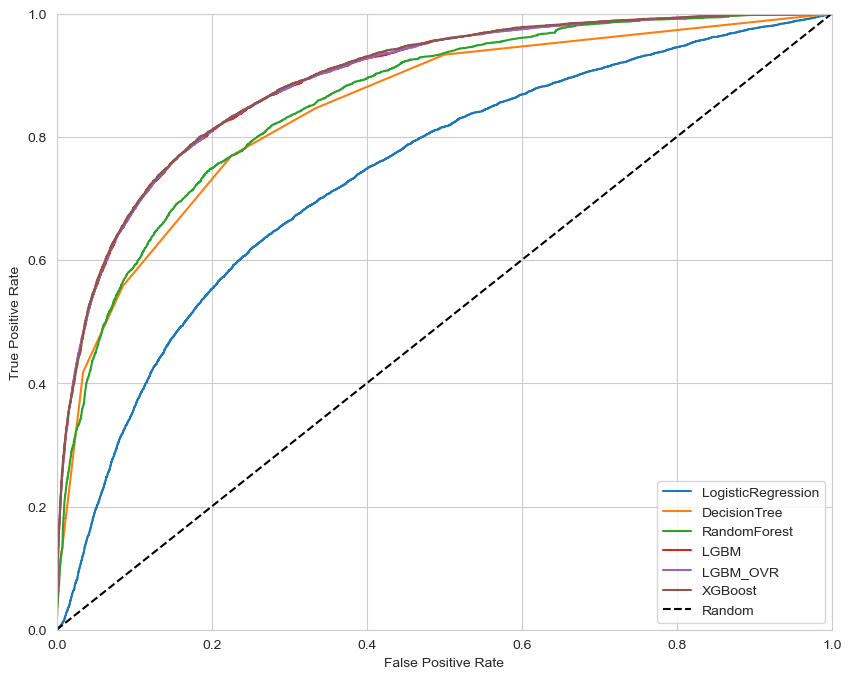

In [25]:
def draw_roc_curve_plot(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for i in range(len(model_names)):
        pred_probas = models[i].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred_probas)
        plt.plot(fpr, tpr, label=model_names[i])
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

draw_roc_curve_plot(models, model_names, X_test, y_test)

In [26]:
lgbm_fi = pd.DataFrame(list(zip(X_train.columns, lgbm.feature_importances_)), 
                       columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
lgbm_fi

,Feature,Importance
1,Age,161
4,NumOfProducts,157
3,Balance,83
6,IsActiveMember,75
0,CreditScore,53
7,EstimatedSalary,48
9,Geography_Germany,47
11,Gender_Female,37
5,HasCrCard,22
2,Tenure,16


## PCA 적용

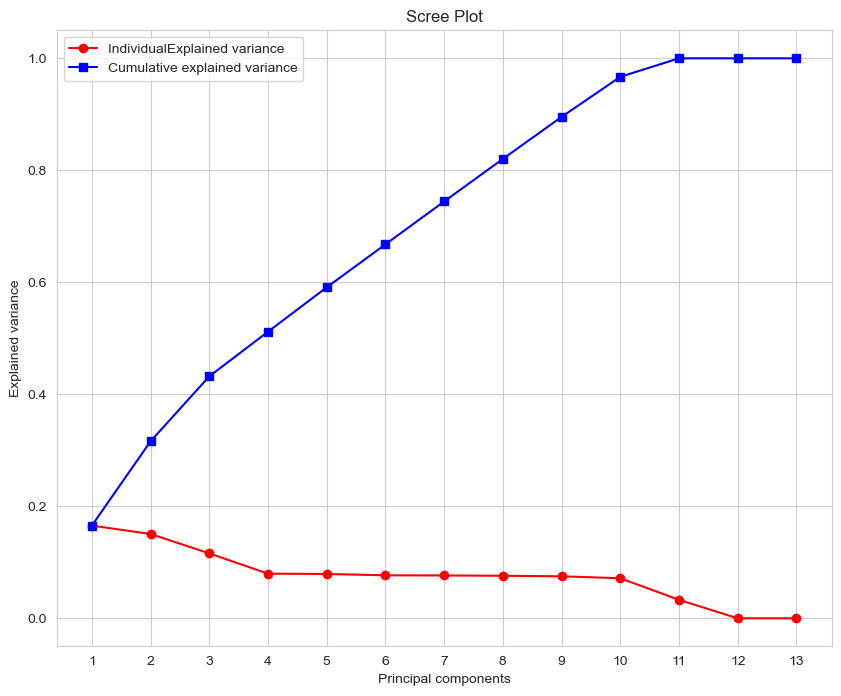

In [27]:
ss = StandardScaler()
ss.fit(X)
X_ss = ss.transform(X)

pca = PCA()
pca.fit(X_ss)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, '-o', color='red', label='IndividualExplained variance')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, '-s', color='blue', label='Cumulative explained variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend()
plt.show()

In [28]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('lgbm', LGBMClassifier(class_weight='balanced', random_state=13, max_depth=3))
])

pipe.fit(X_train, y_train)
pipe_proba = pipe.predict_proba(X_test)
pipe_pred = pipe.predict(X_test)

print_eval(y_test, pipe_pred, pipe_proba[:, 1])

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix
[[20016  6036]
 [ 1502  5453]]
Accuracy: 0.7716 Precision: 0.4746 Recall: 0.784
F1: 0.5913 ROC AUC: 0.8598


## 그리드 서치
- 가장 성능이 좋았던 LGBM, XGBoost에 대해 하이퍼 파라미터 튜닝

In [29]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7], 
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 40, 60]
}

grid_lgbm = GridSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=13),
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=3,
    verbose=False,
    n_jobs=-1
)

grid_lgbm.fit(X_train, y_train)

print('best score :', grid_lgbm.best_score_)
print('best parameters :', grid_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [30]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=13),
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=3,
    verbose=False,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

print('best score :', grid_xgb.best_score_)
print('best parameters :', grid_xgb.best_params_)

best score : 0.8882318822368312
best parameters : {'max_depth': 3, 'n_estimators': 100}


- 하이퍼 파라미터 조정에 따른 성능 향상 정도가 미미함
- XGBoost는 LGBM에 비해 속도가 현저하게 느림

In [31]:
def compare_models(X_train, y_train, X_test, y_test):
    model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LGBM', 'XGBoost']
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    lr = LogisticRegression(class_weight='balanced', random_state=13)
    dt = DecisionTreeClassifier(class_weight='balanced', random_state=13, max_depth=3)
    rf = RandomForestClassifier(class_weight='balanced', random_state=13, max_depth=3)
    lgbm = LGBMClassifier(class_weight='balanced', random_state=13, max_depth=5, num_leaves=63, min_child_samples=60, n_estimators=100)
    xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=13, max_depth=3, n_estimators=100)
    models = [lr, dt, rf, lgbm, xgb]
    result_pd = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
    return result_pd, lgbm, xgb

result, lgbm, xgb = compare_models(X_train, y_train, X_test, y_test)
result

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.680886,0.363122,0.682387,0.474007,0.736675
DecisionTree,0.77323,0.476419,0.769806,0.588578,0.844813
RandomForest,0.777865,0.482853,0.763192,0.591487,0.85726
LGBM,0.812525,0.537367,0.792955,0.640609,0.890886
XGBoost,0.810313,0.53318,0.801725,0.640441,0.891052


In [32]:
def get_feature_importance(lgbm, X_train):
    fi = pd.DataFrame(list(zip(X_train.columns, lgbm.feature_importances_)), 
                        columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
    return fi

fi = get_feature_importance(lgbm, X_train)
fi

,Feature,Importance
1,Age,504
3,Balance,440
7,EstimatedSalary,403
0,CreditScore,401
4,NumOfProducts,243
6,IsActiveMember,204
11,Gender_Female,147
9,Geography_Germany,137
2,Tenure,115
5,HasCrCard,63


## 이상치 제거

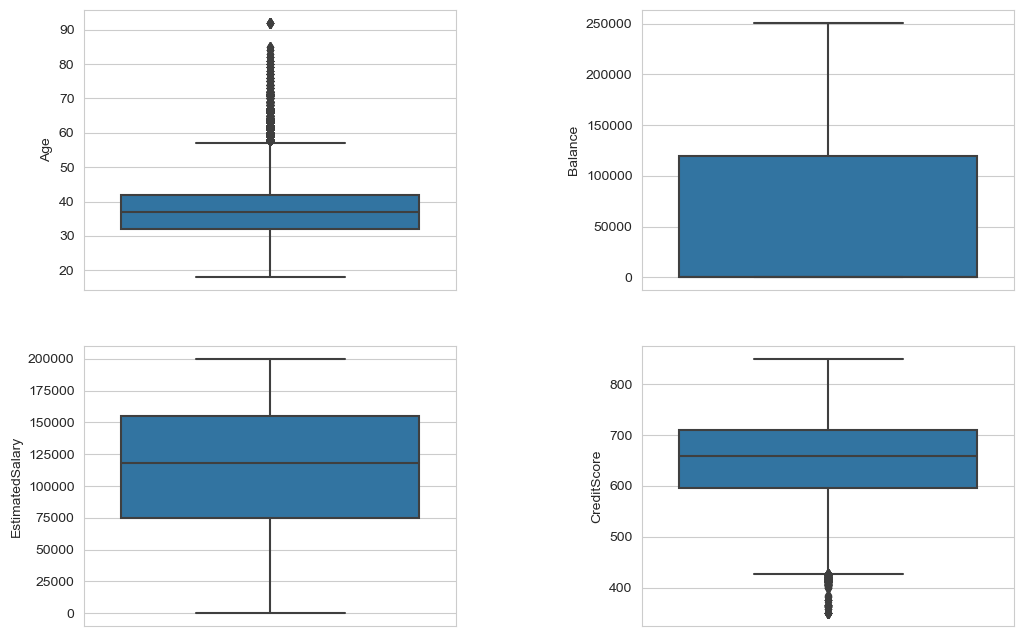

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(y='Age', data=df, ax=ax[0, 0])
sns.boxplot(y='Balance', data=df, ax=ax[0, 1])
sns.boxplot(y='EstimatedSalary', data=df, ax=ax[1, 0])
sns.boxplot(y='CreditScore', data=df, ax=ax[1, 1])
plt.subplots_adjust(wspace=0.5)
plt.show()

In [34]:
def remove_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

df_age = remove_outlier(df, 'Age')
df_clean = remove_outlier(df_age, 'CreditScore')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157416 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               157416 non-null  int64  
 1   CustomerId       157416 non-null  int64  
 2   Surname          157416 non-null  object 
 3   CreditScore      157416 non-null  int64  
 4   Geography        157416 non-null  object 
 5   Gender           157416 non-null  object 
 6   Age              157416 non-null  float64
 7   Tenure           157416 non-null  int64  
 8   Balance          157416 non-null  float64
 9   NumOfProducts    157416 non-null  int64  
 10  HasCrCard        157416 non-null  float64
 11  IsActiveMember   157416 non-null  float64
 12  EstimatedSalary  157416 non-null  float64
 13  Exited           157416 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 18.0+ MB


In [35]:
len(df) - len(df_clean)

7618

In [36]:
df_ohe = pd.get_dummies(df_clean[['Geography', 'Gender']])
pre_ohe = df_clean.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, df_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False,False,True,0
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False,False,True,0
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False,False,True,0
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False,False,True,0
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True,False,True,0


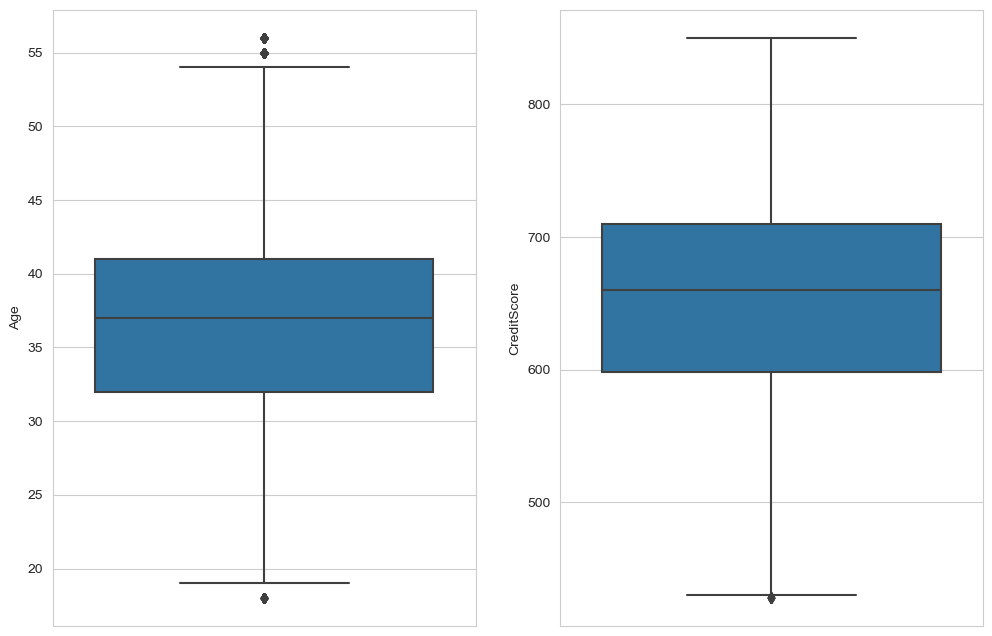

In [37]:
fig, ax = plt.subplots(1, 2,figsize=(12, 8))
sns.boxplot(y='Age', data=df_clean, ax=ax[0])
sns.boxplot(y='CreditScore', data=df_clean, ax=ax[1])
plt.show()

In [38]:
X = data.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
result, lgbm, xgb = compare_models(X_train, y_train, X_test, y_test)
result

[LightGBM] [Info] Number of positive: 25510, number of negative: 100422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 125932, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.672214,0.346049,0.693778,0.461771,0.740707
DecisionTree,0.774838,0.465591,0.750666,0.57472,0.838735
RandomForest,0.782048,0.475885,0.743771,0.580408,0.852343
LGBM,0.809332,0.519598,0.7853,0.625398,0.882258
XGBoost,0.805361,0.512886,0.789061,0.621682,0.881879


In [40]:
fi = get_feature_importance(lgbm, X_train)
fi

,Feature,Importance
3,Balance,498
0,CreditScore,450
1,Age,423
7,EstimatedSalary,417
4,NumOfProducts,240
6,IsActiveMember,205
2,Tenure,154
9,Geography_Germany,145
11,Gender_Female,138
5,HasCrCard,67


- 이상치 제거 후, 성능의 변화가 크진 않지만 지표는 조금씩 하락 - > 차이가 크지 않아 이상치 제거가 모델의 예측 능력에 부정적이라고 평가하긴 어려움 
- 모델의 예측 성능은 유지되면서 특성의 중요도만 변화되었음

> 특성 중요도 변화
- 중요도 상승: Balance, CreditScore, EstimatedSalary의 중요도가 크게 상승. 이상치 제거로 인해 이러한 변수들의 데이터 분포가 모델에 미치는 영향이 더 명확해졌음
- 중요도 하락: Age와 NumOfProducts의 중요도는 상대적으로 감소. 모델이 다른 변수들을 더 중요하게 평가하게 함

## 인코딩 변경

In [41]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [42]:
ndf = df_clean.copy()

le = LabelEncoder()
column_to_encode = ['Geography', 'Gender']

for col in column_to_encode:
    ndf[col] = le.fit_transform(ndf[col])
    print(le.classes_)

['France' 'Germany' 'Spain']
['Female' 'Male']


In [43]:
ndf.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [44]:
X = ndf.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis=1)
y = ndf['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
result, lgbm, xgb = compare_models(X_train, y_train, X_test, y_test)
result

[LightGBM] [Info] Number of positive: 25510, number of negative: 100422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 125932, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.672183,0.345997,0.693622,0.461691,0.740524
DecisionTree,0.774838,0.465591,0.750666,0.57472,0.838735
RandomForest,0.765373,0.453988,0.777778,0.573326,0.855367
LGBM,0.807871,0.517159,0.784046,0.623233,0.881937
XGBoost,0.803837,0.510386,0.789375,0.619938,0.881508


In [46]:
lgbm_fi = pd.DataFrame(list(zip(X_train.columns, lgbm.feature_importances_)), 
                       columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
lgbm_fi

,Feature,Importance
5,Balance,506
0,CreditScore,459
9,EstimatedSalary,408
3,Age,398
6,NumOfProducts,260
1,Geography,218
8,IsActiveMember,198
2,Gender,156
4,Tenure,147
7,HasCrCard,67


> 원핫인코딩 -> 라벨인코딩
- Geography 중요도 증가
    - 원핫인코딩은 각 범주를 별도의 변수로 취급하기에 모델이 특점 범주(거주지가 독일인지 여부)에 어떻게 반응하는지 명확하게 파악할 수 있음
    - 라벨인코딩은 각 범주의 영향을 분리하여 파악하기 어려움
- 기타 특성 중요도 일부 변화

> 어떤 인코딩 방식이 더 적합한가?
- 인코딩 방식에 따른 성능 차이는 거의 없음
- 해석 가능성에 따라 적합한 모델을 선택할 수 있음
    - '독일'의 중요도를 나타나는게 중요한가?
    - Geography의 영향을 종합적으로 평가하는게 더 설명력을 갖나?

## Baseline Model - Predict always '0'
- 불균형 데이터에 대해 항상 0을 예측하는 모델

In [47]:
def baseline_model_predict(X):
    return np.zeros(X.shape[0])

constant_pred = baseline_model_predict(X_test)
constant_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
def get_base_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    pred_proba = np.zeros(y_test.shape[0])
    roc_auc = roc_auc_score(y_test, pred_proba)
    return accuracy, precision, recall, f1, roc_auc

def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    result_pd = pd.DataFrame(columns=col_names, index=model_names)
    for model, model_name in zip(models, model_names):
        accuracy, precision, recall, f1, confusion, roc_score = get_result(model, X_train, y_train, X_test, y_test)
        result_pd.loc[model_name] = [accuracy, precision, recall, f1, roc_score]
    baseline_pred = baseline_model_predict(X_test)
    accuracy, precision, recall, f1, roc_score = get_base_eval(y_test, baseline_pred)
    result_pd.loc['BaselineModel'] = [accuracy, precision, recall, f1, roc_score]
    return result_pd

result, lgbm, xgb = compare_models(X_train, y_train, X_test, y_test)
result

[LightGBM] [Info] Number of positive: 25510, number of negative: 100422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 125932, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\mase8\anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.672183,0.345997,0.693622,0.461691,0.740524
DecisionTree,0.774838,0.465591,0.750666,0.57472,0.838735
RandomForest,0.765373,0.453988,0.777778,0.573326,0.855367
LGBM,0.807871,0.517159,0.784046,0.623233,0.881937
XGBoost,0.803837,0.510386,0.789375,0.619938,0.881508
BaselineModel,0.797326,0.0,0.0,0.0,0.5


- 1로 예측하는 결과가 없기 때문에 TP를 분자로 하는 recall과 precision은 0이 나옴
- 정확도는 전체 데이터셋에서 0의 비율과 같음

# 이상치 제거 후 데이터 비교

In [49]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [50]:
df_clean.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,157416.000000,1.574160e+05,157416.000000,157416.000000,157416.000000,157416.000000,157416.000000,157416.000000,157416.000000,157416.000000,157416.000000
mean,82515.137534,1.569196e+07,656.866170,36.987509,5.024578,55216.444207,1.557809,0.754695,0.489118,112785.794938,0.202591
std,47636.914119,7.138205e+04,79.405377,7.220100,2.803590,62759.930027,0.544275,0.430270,0.499883,50209.519826,0.401931
min,0.000000,1.556570e+07,428.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41254.750000,1.563306e+07,598.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74850.840000,0.000000
50%,82551.500000,1.569016e+07,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,118648.120000,0.000000
75%,123769.250000,1.575682e+07,710.000000,41.000000,7.000000,119782.780000,2.000000,1.000000,1.000000,155639.760000,0.000000
max,165033.000000,1.581569e+07,850.000000,56.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


- max(Age), min(CreditScore) 변화

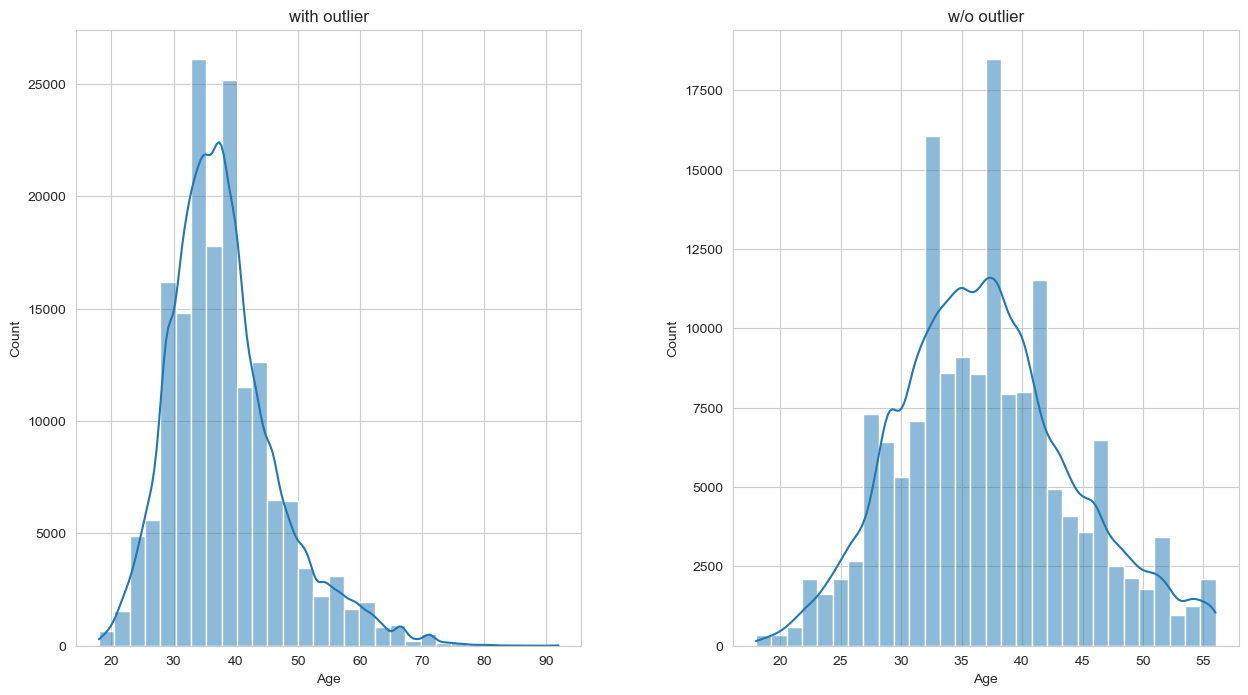

In [51]:
def compare_distribution(df, df_clean, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax0 = sns.histplot(x=col, data=df, ax=ax[0], bins=30, kde=True)
    ax1 = sns.histplot(x=col, data=df_clean, ax=ax[1], bins=30, kde=True)
    ax0.set_title('with outlier')
    ax1.set_title('w/o outlier')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

compare_distribution(df, df_clean, 'Age')

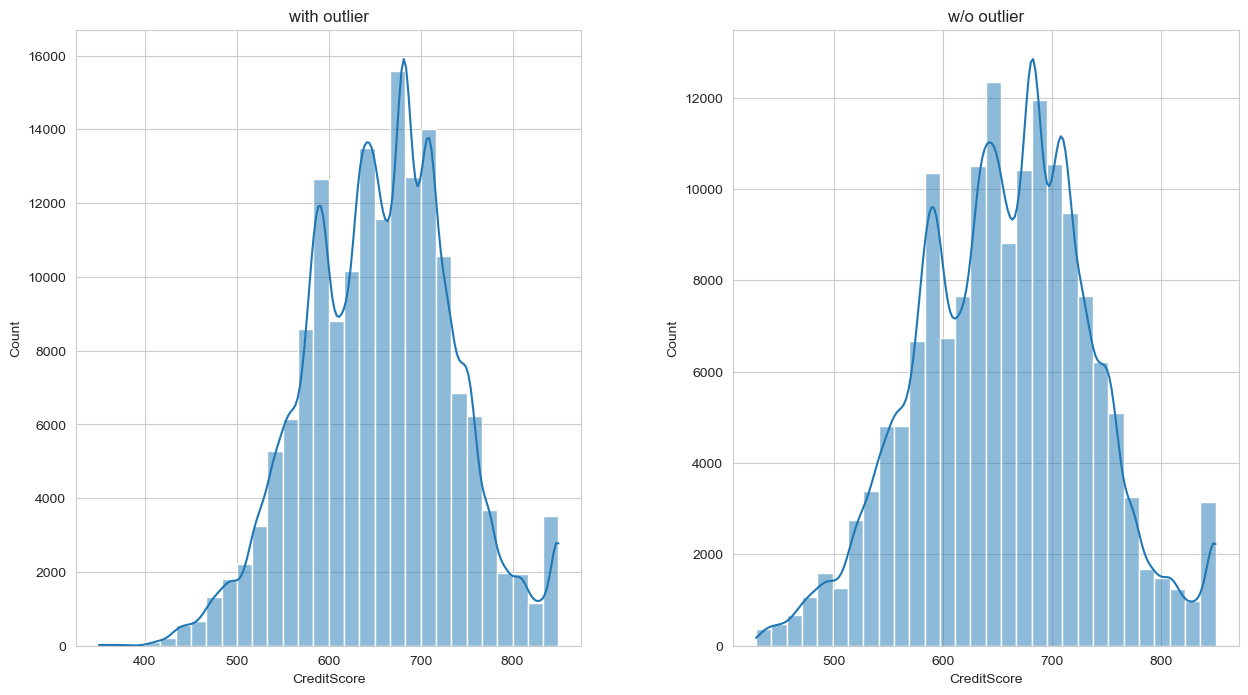

In [52]:
compare_distribution(df, df_clean, 'CreditScore')

- CreditScore, Age 컬럼의 긴 꼬리가 사라지고, 이전보다 좌우대칭 형태에 가까워짐

In [53]:
df_clean.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


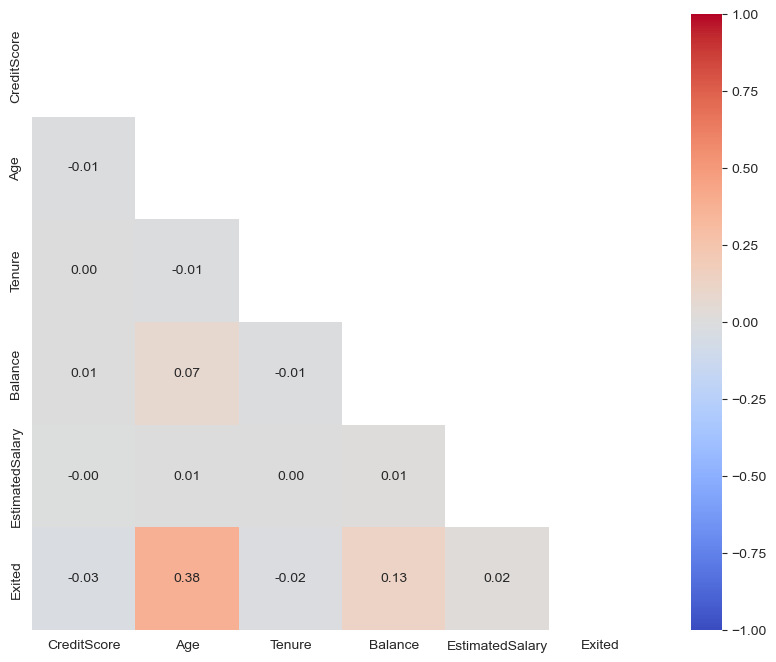

In [54]:
df_digit = df_clean[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']]
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_digit.corr(), dtype=bool))
sns.heatmap(df_digit.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

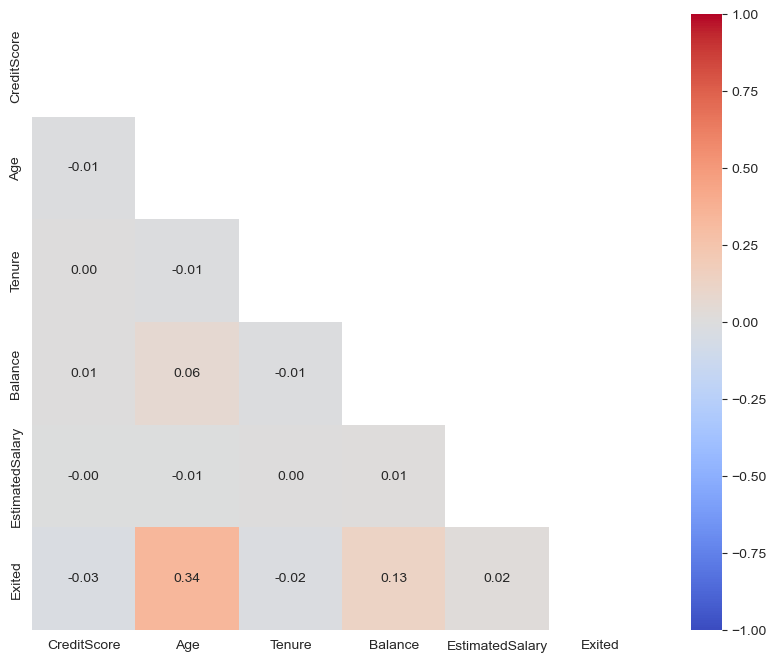

In [55]:
df_digit = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']]
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_digit.corr(), dtype=bool))
sns.heatmap(df_digit.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

- 상대적으로 특성 중요도가 떨어진 'Age'의 상관계수는 오히려 증가
- Balance, CreditScore, EstimatedSalary 등의 변화는 없음

## 앙상블 - VotingClassifier

In [58]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
lgbm = LGBMClassifier(class_weight='balanced', random_state=13, max_depth=5, num_leaves=63, min_child_samples=60, n_estimators=100)
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=13, max_depth=3, n_estimators=100)

vo_clf = VotingClassifier(
    estimators=[('lgbm', lgbm), ('xgb', xgb)], voting='soft', weights=[1, 1],
)

vo_clf.fit(X_train, y_train)
vo_pred = vo_clf.predict(X_test)
vo_proba = vo_clf.predict_proba(X_test)
print('Accuracy : ', accuracy_score(y_test, vo_pred))
print('Precision : ', precision_score(y_test, vo_pred))
print('Recall : ', recall_score(y_test, vo_pred))
print('F1 : ', f1_score(y_test, vo_pred))
print('ROC AUC : ', roc_auc_score(y_test, vo_proba[:, 1]))
confusion_matrix(y_test, vo_pred)

[LightGBM] [Info] Number of positive: 25510, number of negative: 100422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 125932, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

array([[20371,  4732],
       [ 1357,  5024]], dtype=int64)